---
# <center>Dataset creation

In [1]:
import os
import torchaudio

torchaudio.set_audio_backend("sox_io")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
from torchinfo import summary

#################################
# Dataset and Data Preparation  #
#################################

class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None, root="./datasets/speechcommand", download=True):
        os.makedirs(root, exist_ok=True)
        super().__init__(root=root, download=download, subset=subset)

class InMemorySpeechCommands(Dataset):
    def __init__(self, subset="training", fixed_length=16000):
        self.fixed_length = fixed_length
        self.dataset = SubsetSC(subset=subset, root="./datasets/speechcommand", download=True)
        self.data = []
        self.labels = []
        
        dataset_root = self.dataset._path 
        all_labels = sorted([d for d in os.listdir(dataset_root) 
                           if os.path.isdir(os.path.join(dataset_root, d)) and d != '_background_noise_'])
        self.label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
        self.label_set = all_labels
        print(f"Found {len(self.label_set)} labels: {self.label_set}")
        
        # Process each sample
        for waveform, sample_rate, label, *_ in tqdm(self.dataset, desc=f"Loading {subset} data"):
            # Resample if necessary
            if sample_rate != 16000:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)
            waveform = waveform.squeeze(0)
            # Pad or trim to fixed length
            if waveform.size(0) < fixed_length:
                waveform = F.pad(waveform, (0, fixed_length - waveform.size(0)))
            elif waveform.size(0) > fixed_length:
                waveform = waveform[:fixed_length]
            self.data.append(waveform)
            self.labels.append(self.label_to_idx[label])
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.fixed_length, self.labels[idx]


/tmp/ipykernel_35747/2732198263.py:4: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [2]:
import os
import pickle


def get_dataset(subset, fixed_length=16000, pickle_path=None):
    if pickle_path is None:
        pickle_path = f"./datasets/{subset}_dataset.pkl"
    
    if os.path.exists(pickle_path):
        print(f"Loading {subset} dataset from pickle file...")
        with open(pickle_path, "rb") as f:
            dataset = pickle.load(f)
    else:
        print(f"Creating {subset} dataset and saving to pickle...")
        dataset = InMemorySpeechCommands(subset=subset, fixed_length=fixed_length)
        os.makedirs(os.path.dirname(pickle_path), exist_ok=True)
        with open(pickle_path, "wb") as f:
            pickle.dump(dataset, f)
    
    return dataset


train_dataset = get_dataset("training", fixed_length=16000)
val_dataset = get_dataset("validation", fixed_length=16000)
test_dataset = get_dataset(subset = "testing", fixed_length=16000)

num_classes = len(test_dataset.label_set)


Loading training dataset from pickle file...
Loading validation dataset from pickle file...
Loading testing dataset from pickle file...


In [3]:
# print length of datasets
print(f"Train dataset: {len(train_dataset)}")
print(f"Validation dataset: {len(val_dataset)}")
print(f"Test dataset: {len(test_dataset)}")


Train dataset: 84843
Validation dataset: 9981
Test dataset: 11005


---
# <center>Model Architecture

In [4]:
from model import EncDecClassificationModel

model = EncDecClassificationModel(num_classes=num_classes, sample_rate=16000)

summary(model, input_data=(torch.randn(1, 16000) , torch.tensor([16000])))

Layer (type:depth-idx)                             Output Shape              Param #
EncDecClassificationModel                          [1, 35]                   --
├─AudioToMFCCPreprocessor: 1-1                     [1, 64, 101]              --
│    └─MFCC: 2-1                                   [1, 64, 101]              --
│    │    └─MelSpectrogram: 3-1                    [1, 64, 101]              --
│    │    └─AmplitudeToDB: 3-2                     [1, 64, 101]              --
├─ConvASREncoder: 1-2                              [1, 128, 101]             --
│    └─Sequential: 2-2                             --                        --
│    │    └─JasperBlock: 3-3                       [1, 128, 101]             9,152
│    │    └─JasperBlock: 3-4                       [1, 64, 101]              18,304
│    │    └─JasperBlock: 3-5                       [1, 64, 101]              9,408
│    │    └─JasperBlock: 3-6                       [1, 64, 101]              9,536
│    │    └─JasperBloc

---
# <center>Training

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from training_utils import run_training_classification

# Configuration
experiment_name = "classification_experiment"
num_epochs = 20
batch_size = 64
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_losses, train_accuracies, val_losses, val_accuracies, step_history = run_training_classification(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer_class=optim.Adam,
    optimizer_params={'lr': learning_rate},
    scheduler_class=optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={'mode': 'min', 'factor': 0.5, 'patience': 5},
    num_epochs=num_epochs,
    device=device,
    batch_size=batch_size,
    num_workers=4,
    resume_training=False,
    experiment_name=experiment_name,
    checkpoint_frequency=None 
)

history = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "step_history": step_history
}
with open(f"checkpoints/{experiment_name}/training_history.json", "w") as f:
    json.dump(history, f, indent=4)


Checkpoint saved to checkpoints/classification_experiment/checkpoint_0_1326_best.pt
New best model saved with val loss: 0.3399 and val acc: 90.36%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_0_1326.pt
Epoch [1/20] Train Loss: 0.8127 | Train Acc: 77.89% | Val Loss: 0.3399 | Val Acc: 90.36%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_1_2652_best.pt
New best model saved with val loss: 0.2595 and val acc: 92.45%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_1_2652.pt
Epoch [2/20] Train Loss: 0.3079 | Train Acc: 90.83% | Val Loss: 0.2595 | Val Acc: 92.45%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_2_3978_best.pt
New best model saved with val loss: 0.2276 and val acc: 93.08%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_2_3978.pt
Epoch [3/20] Train Loss: 0.2453 | Train Acc: 92.61% | Val Loss: 0.2276 | Val Acc: 93.08%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_3_5304_best.pt
New best model saved with val loss: 0.2176 and val acc: 93.54%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_3_5304.pt
Epoch [4/20] Train Loss: 0.2161 | Train Acc: 93.40% | Val Loss: 0.2176 | Val Acc: 93.54%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_4_6630_best.pt
New best model saved with val loss: 0.2148 and val acc: 93.66%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_4_6630.pt
Epoch [5/20] Train Loss: 0.1910 | Train Acc: 94.10% | Val Loss: 0.2148 | Val Acc: 93.66%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_5_7956_best.pt
New best model saved with val loss: 0.2046 and val acc: 94.02%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_5_7956.pt
Epoch [6/20] Train Loss: 0.1718 | Train Acc: 94.63% | Val Loss: 0.2046 | Val Acc: 94.02%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_6_9282.pt
Epoch [7/20] Train Loss: 0.1585 | Train Acc: 95.09% | Val Loss: 0.2096 | Val Acc: 94.01%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_7_10608_best.pt
New best model saved with val loss: 0.1999 and val acc: 94.37%
Checkpoint saved to checkpoints/classification_experiment/checkpoint_7_10608.pt
Epoch [8/20] Train Loss: 0.1487 | Train Acc: 95.31% | Val Loss: 0.1999 | Val Acc: 94.37%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_8_11934.pt
Epoch [9/20] Train Loss: 0.1351 | Train Acc: 95.79% | Val Loss: 0.2161 | Val Acc: 94.12%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_9_13260.pt
Epoch [10/20] Train Loss: 0.1277 | Train Acc: 95.95% | Val Loss: 0.2111 | Val Acc: 94.46%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_10_14586.pt
Epoch [11/20] Train Loss: 0.1183 | Train Acc: 96.28% | Val Loss: 0.2257 | Val Acc: 94.31%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_11_15912.pt
Epoch [12/20] Train Loss: 0.1113 | Train Acc: 96.52% | Val Loss: 0.2144 | Val Acc: 94.41%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_12_17238.pt
Epoch [13/20] Train Loss: 0.1081 | Train Acc: 96.55% | Val Loss: 0.2246 | Val Acc: 94.34%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_13_18564.pt
Epoch [14/20] Train Loss: 0.0984 | Train Acc: 96.83% | Val Loss: 0.2249 | Val Acc: 94.63%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_14_19890.pt
Epoch [15/20] Train Loss: 0.0697 | Train Acc: 97.89% | Val Loss: 0.2135 | Val Acc: 94.92%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_15_21216.pt
Epoch [16/20] Train Loss: 0.0617 | Train Acc: 98.17% | Val Loss: 0.2285 | Val Acc: 94.81%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_16_22542.pt
Epoch [17/20] Train Loss: 0.0600 | Train Acc: 98.18% | Val Loss: 0.2323 | Val Acc: 94.70%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_17_23868.pt
Epoch [18/20] Train Loss: 0.0584 | Train Acc: 98.23% | Val Loss: 0.2284 | Val Acc: 94.71%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_18_25194.pt
Epoch [19/20] Train Loss: 0.0530 | Train Acc: 98.42% | Val Loss: 0.2405 | Val Acc: 94.55%


Checkpoint saved to checkpoints/classification_experiment/checkpoint_19_26520.pt
Epoch [20/20] Train Loss: 0.0523 | Train Acc: 98.43% | Val Loss: 0.2412 | Val Acc: 94.81%


In [20]:
train_losses = history["train_losses"]
val_losses = history["val_losses"]
train_accuracies = history["train_accuracies"]
val_accuracies = history["val_accuracies"]
step_history = history["step_history"]


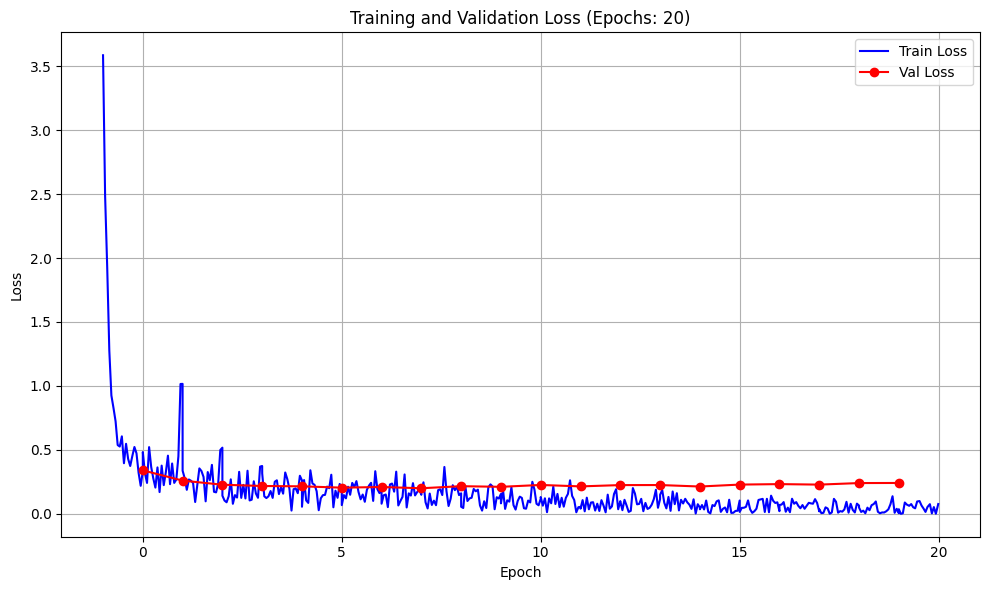

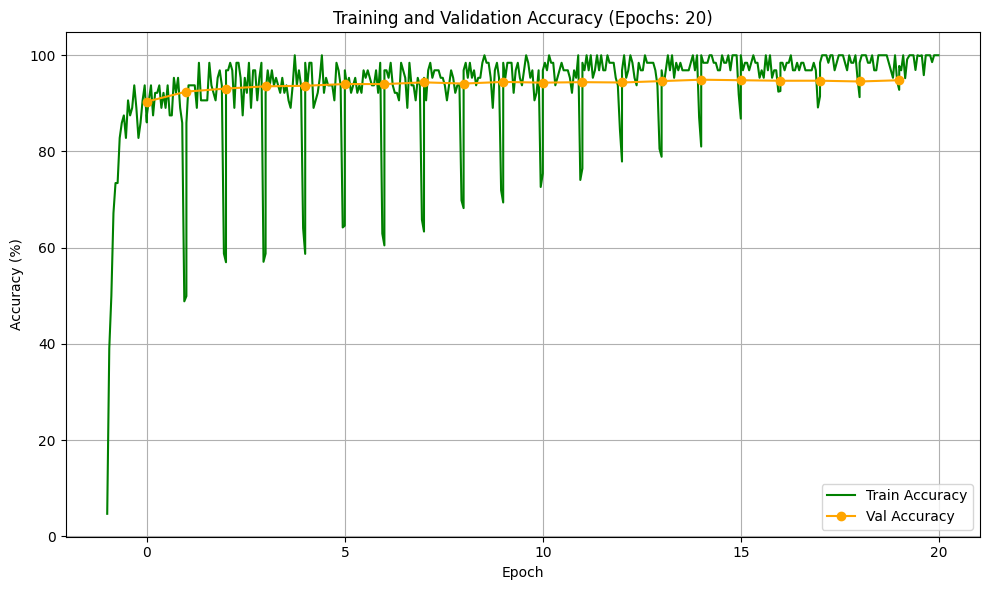

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

max_steps_per_epoch = 20  


epoch_groups = defaultdict(list)
for entry in step_history:
    epoch_groups[entry["epoch"]].append(entry)


train_x = []
train_losses = []
train_accuracies = []


for epoch in sorted(epoch_groups.keys()):
    steps = epoch_groups[epoch]
    n_steps = len(steps)
    if n_steps > max_steps_per_epoch:
        indices = np.linspace(0, n_steps - 1, max_steps_per_epoch, dtype=int)
    else:
        indices = np.arange(n_steps)
    for i in indices:
        entry = steps[i]
        x_val = (epoch - 1) + (i / n_steps)
        train_x.append(x_val)
        train_losses.append(entry["loss"])
        train_accuracies.append(entry["accuracy"])

val_x = np.arange(num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(train_x, train_losses, label='Train Loss', color='blue')
plt.plot(val_x, val_losses, label='Val Loss', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss (Epochs: {num_epochs})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_x, train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_x, val_accuracies, label='Val Accuracy', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training and Validation Accuracy (Epochs: {num_epochs})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluating: 100%|██████████| 172/172 [00:01<00:00, 108.30it/s]


Test Accuracy: 94.02%


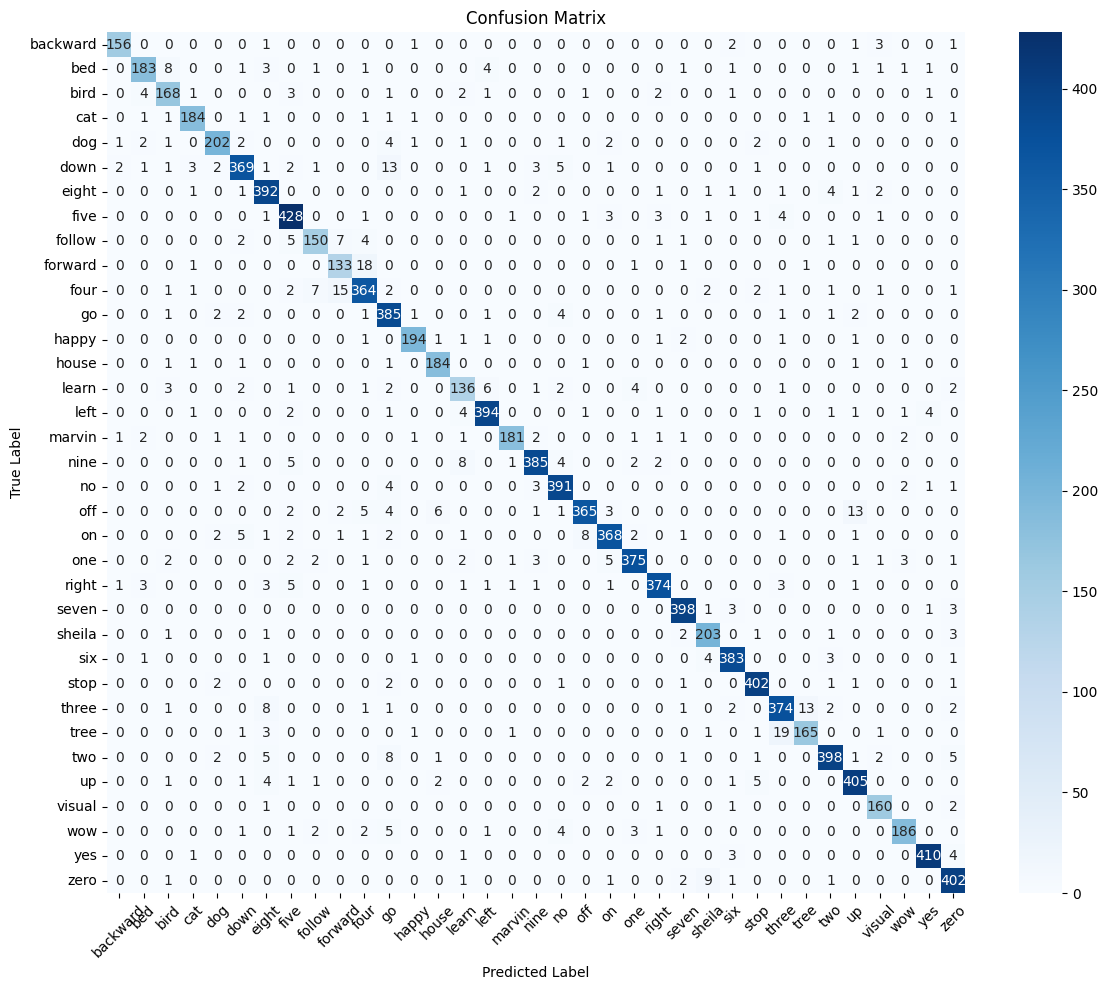

Classification Report:
               precision    recall  f1-score   support

    backward       0.97      0.95      0.96       165
         bed       0.93      0.88      0.91       207
        bird       0.88      0.91      0.89       185
         cat       0.95      0.95      0.95       194
         dog       0.94      0.92      0.93       220
        down       0.94      0.91      0.92       406
       eight       0.92      0.96      0.94       408
        five       0.93      0.96      0.94       445
      follow       0.91      0.87      0.89       172
     forward       0.84      0.86      0.85       155
        four       0.90      0.91      0.91       400
          go       0.88      0.96      0.92       402
       happy       0.97      0.96      0.96       203
       house       0.95      0.96      0.96       191
       learn       0.85      0.84      0.85       161
        left       0.96      0.96      0.96       412
      marvin       0.97      0.93      0.95       195
   

/tmp/ipykernel_35747/1926442173.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_names, y=per_class_accuracy, palette="viridis")


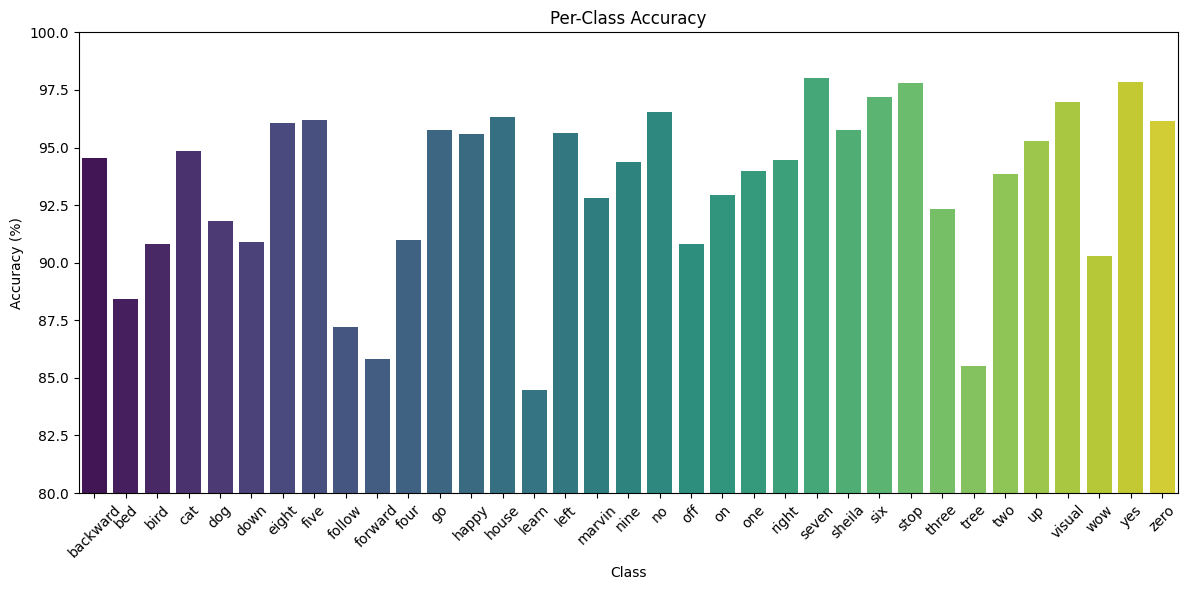

In [7]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = EncDecClassificationModel(num_classes=35, sample_rate=16000)
# state_dict = torch.load('./best_model.pth', map_location=torch.device('cpu'))
# model.load_state_dict(state_dict)
# model = model.to(device)

# load from last checkpoint
# experiment_name = "classification_experiment"
# checkpoint = torch.load(f"checkpoints/{experiment_name}/checkpoint_49_82700.pt", map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])
# model = model.to(device)




def evaluate_model(model, test_dataset, device, batch_size=64, num_workers=4):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, fixed_length, labels in tqdm(test_loader, desc="Evaluating"):
            data = data.to(device)
            labels = labels.to(device)
            if isinstance(fixed_length, torch.Tensor):
                fixed_length_val = int(fixed_length[0].item())
            else:
                fixed_length_val = fixed_length
            
            lengths = torch.full((data.size(0),), fixed_length_val, dtype=torch.long, device=device)
            logits = model(data, lengths)
            preds = torch.argmax(logits, dim=-1)
            
            total_correct += (preds == labels).sum().item()
            total_samples += data.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    overall_accuracy = total_correct / total_samples * 100
    return overall_accuracy, all_preds, all_targets

test_accuracy, all_preds, all_targets = evaluate_model(model, test_dataset, device=device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# --- Plotting the results ---

cm = confusion_matrix(all_targets, all_preds)
labels_names = test_dataset.label_set  # list of label names in sorted order

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Classification Report (printed)
report = classification_report(all_targets, all_preds, target_names=labels_names)
print("Classification Report:\n", report)

# 3. Per-Class Accuracy Bar Chart
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
per_class_accuracy = np.diag(cm_normalized) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=labels_names, y=per_class_accuracy, palette="viridis")
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.ylim(80, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


----
# <center> MIT model

In [8]:
import time
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

try:
    from ptflops import get_model_complexity_info
except ImportError:
    get_model_complexity_info = None

# ------------------------------
# Load MIT Model
# ------------------------------
mit_model_name = "MIT/ast-finetuned-speech-commands-v2"
feature_extractor = AutoFeatureExtractor.from_pretrained(mit_model_name)
mit_model = AutoModelForAudioClassification.from_pretrained(mit_model_name)
mit_model.to(device)
mit_model.eval()

dummy_waveform = np.random.randn(16000) 
inputs = feature_extractor(dummy_waveform, sampling_rate=16000, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()} # move inputs to device

# Now use torchinfo to get a summary:
from torchinfo import summary
summary(mit_model, input_data=inputs)


2025-02-21 04:59:35.219215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740110375.228691   35747 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740110375.231590   35747 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 04:59:35.242637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Layer (type:depth-idx)                                       Output Shape              Param #
ASTForAudioClassification                                    [1, 35]                   --
├─ASTModel: 1-1                                              [1, 768]                  --
│    └─ASTEmbeddings: 2-1                                    [1, 146, 768]             113,664
│    │    └─ASTPatchEmbeddings: 3-1                          [1, 144, 768]             197,376
│    │    └─Dropout: 3-2                                     [1, 146, 768]             --
│    └─ASTEncoder: 2-2                                       [1, 146, 768]             --
│    │    └─ModuleList: 3-3                                  --                        85,054,464
│    └─LayerNorm: 2-3                                        [1, 146, 768]             1,536
├─ASTMLPHead: 1-2                                            [1, 35]                   --
│    └─LayerNorm: 2-4                                        [1, 768]     

# MIT model

In [ ]:
def evaluate_mit_model(mit_model, feature_extractor, test_dataset, device, batch_size=64, num_workers=12, num_runs=11):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    mit_id2label = mit_model.config.id2label
    key_type = type(list(mit_id2label.keys())[0])

    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    batch_inference_times = []
    batch_fe_times = []
    batch_inf_times = []
    use_cuda_timing = device.type == 'cuda'

    # Warm-up (discard first run, do a few)
    for _ in range(3):  # A few warm-up iterations
      data, _, _ = next(iter(test_loader))
      audio_samples = [waveform.cpu().numpy() for waveform in data]
      inputs = feature_extractor(audio_samples, sampling_rate=16000, return_tensors="pt", padding=True)
      inputs = {k: v.to(device) for k, v in inputs.items()}
      with torch.inference_mode():
          mit_model(**inputs)  # Don't need outputs during warm-up

    for _ in range(num_runs): #  loop for averaging
        run_correct = 0
        run_samples = 0
        run_preds = []
        run_targets = []
        run_batch_inference_times = []
        run_batch_fe_times = []
        run_batch_inf_times = []

        with torch.inference_mode(): 
            for data, fixed_length, labels in tqdm(test_loader, desc="Evaluating MIT Model", leave=False):

                audio_samples = [waveform.cpu().numpy() for waveform in data]

                # --- Feature Extraction Timing ---
                if use_cuda_timing:
                    torch.cuda.synchronize()
                    fe_start = torch.cuda.Event(enable_timing=True)
                    fe_end = torch.cuda.Event(enable_timing=True)
                    fe_start.record()
                else:
                    fe_start_time = time.time()

                inputs = feature_extractor(audio_samples, sampling_rate=16000, return_tensors="pt", padding=True)
                inputs = {k: v.to(device) for k, v in inputs.items()}

                if use_cuda_timing:
                    fe_end.record()
                    torch.cuda.synchronize()
                    fe_time = fe_start.elapsed_time(fe_end) / 1000.0
                else:
                    fe_time = time.time() - fe_start_time

                # --- Model Inference Timing ---
                if use_cuda_timing:
                    torch.cuda.synchronize()
                    inf_start = torch.cuda.Event(enable_timing=True)
                    inf_end = torch.cuda.Event(enable_timing=True)
                    inf_start.record()
                else:
                    inf_start_time = time.time()

                outputs = mit_model(**inputs)

                if use_cuda_timing:
                    inf_end.record()
                    torch.cuda.synchronize()
                    inf_time = inf_start.elapsed_time(inf_end) / 1000.0
                else:
                    inf_time = time.time() - inf_start_time

                batch_time = fe_time + inf_time
                run_batch_inference_times.append(batch_time)
                run_batch_fe_times.append(fe_time)
                run_batch_inf_times.append(inf_time)

                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)

                # Remap predictions to match test dataset labels
                remapped_preds = []
                for pred in preds.cpu().numpy():
                    if key_type is int:
                        mit_label = mit_id2label[pred]
                    else:
                        mit_label = mit_id2label[str(pred)]
                    try:
                        remapped_idx = test_dataset.label_set.index(mit_label)
                    except ValueError:
                        print(f"Warning: label '{mit_label}' not found in test dataset labels.")
                        remapped_idx = -1  # Or some other default value
                    remapped_preds.append(remapped_idx)

                labels = labels.to(device)
                run_correct += (torch.tensor(remapped_preds, device=device) == labels).sum().item()
                run_samples += data.size(0)

                run_preds.extend(remapped_preds)
                run_targets.extend(labels.cpu().numpy())
        # Accumulate results after the inner loop (over batches):
        if _ > 0: #  skip first run
            total_correct += run_correct
            total_samples += run_samples
            all_preds.extend(run_preds)
            all_targets.extend(run_targets)
            batch_inference_times.extend(run_batch_inference_times)  # Accumulate batch times
            batch_fe_times.extend(run_batch_fe_times)
            batch_inf_times.extend(run_batch_inf_times)

    overall_accuracy = total_correct / total_samples * 100 / (num_runs - 1) #  average accuracy, exclude first run
    total_inference_time = np.sum(batch_inference_times)
    avg_batch_time = np.mean(batch_inference_times)  # Average over all batches and runs
    avg_sample_time = total_inference_time / (total_samples * (num_runs -1)) # total samples

    timing_info = {
        "total_inference_time_sec": total_inference_time,
        "avg_batch_time_sec": avg_batch_time,
        "avg_sample_time_sec": avg_sample_time,
        "num_samples": total_samples,
        "batch_times": batch_inference_times,
        "fe_times": batch_fe_times,
        "inf_times": batch_inf_times
    }

    return overall_accuracy, all_preds, all_targets, timing_info



def single_inference_mit(mit_model, feature_extractor, test_dataset, device, num_runs=101): # added num_runs
    data, fixed_length, label = test_dataset[0]
    audio_sample = data.cpu().numpy()

    # Warm-up (single sample)
    for _ in range(3):
        single_input = feature_extractor([audio_sample], sampling_rate=16000, return_tensors="pt", padding=True)
        single_input = {k: v.to(device) for k, v in single_input.items()}
        with torch.inference_mode():
          mit_model(**single_input)

    total_times = []
    fe_times = []
    inf_times = []

    for _ in range(num_runs): #  loop for averaging
        single_input = feature_extractor([audio_sample], sampling_rate=16000, return_tensors="pt", padding=True)
        single_input = {k: v.to(device) for k, v in single_input.items()}

        # Time feature extraction for the single sample
        if device.type == 'cuda':
            torch.cuda.synchronize()
            single_fe_start = torch.cuda.Event(enable_timing=True)
            single_fe_end = torch.cuda.Event(enable_timing=True)
            single_fe_start.record()
        else:
            single_fe_start_time = time.time()


        if device.type == 'cuda':
            single_fe_end.record()
            torch.cuda.synchronize()
            single_fe_time = single_fe_start.elapsed_time(single_fe_end) / 1000.0
        else:
            single_fe_time = time.time() - single_fe_start_time

        if device.type == 'cuda':
            torch.cuda.synchronize()
            single_inf_start = torch.cuda.Event(enable_timing=True)
            single_inf_end = torch.cuda.Event(enable_timing=True)
            single_inf_start.record()
        else:
            single_inf_start_time = time.time()

        with torch.inference_mode():
          output_single = mit_model(**single_input)

        if device.type == 'cuda':
            single_inf_end.record()
            torch.cuda.synchronize()
            single_inf_time = single_inf_start.elapsed_time(single_inf_end) / 1000.0
        else:
            single_inf_time = time.time() - single_inf_start_time

        single_total_time = single_fe_time + single_inf_time

        if _ > 0:
            total_times.append(single_total_time)
            fe_times.append(single_fe_time)
            inf_times.append(single_inf_time)
    # Average times (excluding the first run)
    avg_total_time = np.mean(total_times)
    avg_fe_time = np.mean(fe_times)
    avg_inf_time = np.mean(inf_times)


    pred_single_mit = torch.argmax(output_single.logits, dim=-1).item()
    mit_id2label = mit_model.config.id2label
    if isinstance(list(mit_id2label.keys())[0], int):
        predicted_label = mit_id2label[pred_single_mit]
    else:
        predicted_label = mit_id2label[str(pred_single_mit)]

    print(f"\nMIT Model Single Sample Inference:")
    print(f"  Avg Feature extraction time: {avg_fe_time:.6f} seconds")
    print(f"  Avg Inference time: {avg_inf_time:.6f} seconds")
    print(f"  Avg Total time: {avg_total_time:.6f} seconds")
    print(f"  Predicted class index: {pred_single_mit}, label: {predicted_label}")
    print(f"  True label: {label}")
    return avg_total_time, avg_fe_time, avg_inf_time  # Return the averages

# -----------------------------------------------------------------------------
#  Compute FLOPs for MIT Model
# -----------------------------------------------------------------------------
if 'get_model_complexity_info' in globals() and get_model_complexity_info is not None:
    dummy_waveform = np.zeros(16000, dtype=np.float32)
    inputs_dummy = feature_extractor([dummy_waveform], sampling_rate=16000, return_tensors="pt", padding=True)
    dummy_input = inputs_dummy["input_values"]
    print("Dummy input shape for FLOPs estimation:", dummy_input.shape)
    input_res = tuple(dummy_input.shape[1:])
    macs, params = get_model_complexity_info(mit_model, input_res, as_strings=True,
                                               print_per_layer_stat=False, verbose=False)
    print(f"MIT Model FLOPs: {macs}, Params: {params}")

# -----------------------------------------------------------------------------
# Evaluate MIT Model on Test Dataset
# -----------------------------------------------------------------------------
mit_accuracy, mit_all_preds, mit_all_targets, mit_timing = evaluate_mit_model(
    mit_model, feature_extractor, test_dataset, device=device
)
print(f"MIT Model Test Accuracy: {mit_accuracy:.2f}%")
print("Inference Timing Info (MIT Model):")
for key, val in mit_timing.items():
    if key not in ["batch_times", "fe_times", "inf_times"]:
        print(f"  {key}: {val:.6f}" if isinstance(val, float) else f"  {key}: {val}")

# -----------------------------------------------------------------------------
# Single Sample Inference for MIT Model
# -----------------------------------------------------------------------------
data, fixed_length, label = test_dataset[0]
audio_sample = data.cpu().numpy() if torch.is_tensor(data) else data

single_input = feature_extractor([audio_sample], sampling_rate=16000, return_tensors="pt", padding=True)
single_input = {k: v.to(device) for k, v in single_input.items()}

# Time feature extraction for the single sample
if device.type == 'cuda':
    torch.cuda.synchronize()
    single_fe_start = torch.cuda.Event(enable_timing=True)
    single_fe_end = torch.cuda.Event(enable_timing=True)
    single_fe_start.record()
else:
    single_fe_start_time = time.time()

if device.type == 'cuda':
    single_fe_end.record()
    torch.cuda.synchronize()
    single_fe_time = single_fe_start.elapsed_time(single_fe_end) / 1000.0
else:
    single_fe_time = time.time() - single_fe_start_time

if device.type == 'cuda':
    torch.cuda.synchronize()
    single_inf_start = torch.cuda.Event(enable_timing=True)
    single_inf_end = torch.cuda.Event(enable_timing=True)
    single_inf_start.record()
else:
    single_inf_start_time = time.time()

output_single = mit_model(**single_input)

if device.type == 'cuda':
    single_inf_end.record()
    torch.cuda.synchronize()
    single_inf_time = single_inf_start.elapsed_time(single_inf_end) / 1000.0
else:
    single_inf_time = time.time() - single_inf_start_time

single_total_time = single_fe_time + single_inf_time
mit_single_time = single_total_time  

pred_single_mit = torch.argmax(output_single.logits, dim=-1).item()
mit_id2label = mit_model.config.id2label
if isinstance(list(mit_id2label.keys())[0], int):
    predicted_label = mit_id2label[pred_single_mit]
else:
    predicted_label = mit_id2label[str(pred_single_mit)]

print(f"\nMIT Model Single Sample Inference:")
print(f"  Feature extraction time: {single_fe_time:.6f} seconds")
print(f"  Inference time: {single_inf_time:.6f} seconds")
print(f"  Total time: {single_total_time:.6f} seconds")
print(f"  Predicted class index: {pred_single_mit}, label: {predicted_label}")
print(f"  True label: {label}")

Dummy input shape for FLOPs estimation: torch.Size([1, 128, 128])
MIT Model FLOPs: 12.44 GMac, Params: 85.4 M


MIT Model Test Accuracy: 9.80%
Inference Timing Info (MIT Model):
  total_inference_time_sec: 235.563838
  avg_batch_time_sec: 0.136956
  avg_sample_time_sec: 0.000214
  num_samples: 110050

MIT Model Single Sample Inference:
  Feature extraction time: 0.000083 seconds
  Inference time: 0.006309 seconds
  Total time: 0.006392 seconds
  Predicted class index: 18, label: right
  True label: 22


# Custom Model

In [38]:
def evaluate_custom_model(model, test_dataset, device, batch_size=64, num_workers=4, num_runs=11):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval()

    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    batch_inference_times = []
    use_cuda_timing = device.type == 'cuda'

    # Warm-up
    for _ in range(3):  # A few warm-up iterations
        data, fixed_length, _ = next(iter(test_loader))
        data = data.to(device)
        lengths = torch.full((data.size(0),), int(fixed_length[0].item()), dtype=torch.long, device=device)
        with torch.inference_mode():
            model(data, lengths)

    for _ in range(num_runs):
        run_correct = 0
        run_samples = 0
        run_preds = []
        run_targets = []
        run_batch_inference_times = []


        with torch.inference_mode():
            for data, fixed_length, labels in tqdm(test_loader, desc="Evaluating Custom Model", leave=False):
                data = data.to(device)
                labels = labels.to(device)
                # determine the fixed length value
                if isinstance(fixed_length, torch.Tensor):
                    fixed_length_val = int(fixed_length[0].item())
                else:
                    fixed_length_val = fixed_length
                # create a lengths tensor for the batch
                lengths = torch.full((data.size(0),), fixed_length_val, dtype=torch.long, device=device)

                # time the inference for this batch
                if use_cuda_timing:
                    torch.cuda.synchronize()
                    start_event = torch.cuda.Event(enable_timing=True)
                    end_event = torch.cuda.Event(enable_timing=True)
                    start_event.record()
                else:
                    start_time = time.time()

                logits = model(data, lengths)

                if use_cuda_timing:
                    end_event.record()
                    torch.cuda.synchronize()
                    batch_time = start_event.elapsed_time(end_event) / 1000.0  # convert ms to s
                else:
                    batch_time = time.time() - start_time
                run_batch_inference_times.append(batch_time)

                preds = torch.argmax(logits, dim=-1)
                run_correct += (preds == labels).sum().item()
                run_samples += data.size(0)
                run_preds.extend(preds.cpu().numpy())
                run_targets.extend(labels.cpu().numpy())
        if _ > 0:
          total_correct += run_correct
          total_samples += run_samples
          all_preds.extend(run_preds)
          all_targets.extend(run_targets)
          batch_inference_times.extend(run_batch_inference_times)

    overall_accuracy = total_correct / total_samples * 100 / (num_runs-1)
    total_inference_time = np.sum(batch_inference_times)
    avg_batch_time = np.mean(batch_inference_times)
    avg_sample_time = total_inference_time / (total_samples * (num_runs -1))

    timing_info = {
        "total_inference_time_sec": total_inference_time,
        "avg_batch_time_sec": avg_batch_time,
        "avg_sample_time_sec": avg_sample_time,
        "num_samples": total_samples,
        "batch_times": batch_inference_times
    }

    return overall_accuracy, all_preds, all_targets, timing_info


def single_inference_custom(model, test_dataset, device, num_runs=101):
    data, fixed_length, label = test_dataset[0]
    data = data.to(device)
    if isinstance(fixed_length, torch.Tensor):
        fixed_length_val = int(fixed_length.item())
    else:
        fixed_length_val = fixed_length
    lengths = torch.tensor([fixed_length_val], dtype=torch.long, device=device)
    data = data.unsqueeze(0)

    # Warm-up (single sample)
    for _ in range(3):
      with torch.inference_mode():
        model(data, lengths)


    total_times = []
    use_cuda_timing = device.type == 'cuda'

    for _ in range(num_runs):

        if use_cuda_timing:
            torch.cuda.synchronize()
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
        else:
            start_time = time.time()

        with torch.inference_mode():
            logits = model(data, lengths)

        if use_cuda_timing:
            end_event.record()
            torch.cuda.synchronize()
            custom_single_time = start_event.elapsed_time(end_event) / 1000.0
        else:
            custom_single_time = time.time() - start_time

        if _ > 0:
            total_times.append(custom_single_time)

    avg_single_time = np.mean(total_times) # average, excluding first run



    pred_single_custom = torch.argmax(logits, dim=-1).item()
    print(f"\nCustom Model Single Sample Inference:")
    print(f"  Avg Inference time: {avg_single_time:.6f} seconds")
    print(f"  Predicted class index: {pred_single_custom}")
    print(f"  True label: {label}")
    return avg_single_time

# -----------------------------------------------------------------------------
# Evaluate Custom Model on Test Dataset
# -----------------------------------------------------------------------------
custom_accuracy, custom_all_preds, custom_all_targets, custom_timing = evaluate_custom_model(
    model, test_dataset, device=device
)
print(f"Custom Model Test Accuracy: {custom_accuracy:.2f}%")
print("Inference Timing Info (Custom Model):")
for key, val in custom_timing.items():
    if key != "batch_times":
        print(f"  {key}: {val:.6f}" if isinstance(val, float) else f"  {key}: {val}")

# -----------------------------------------------------------------------------
# Single Sample Inference for Custom Model
# -----------------------------------------------------------------------------
data, fixed_length, label = test_dataset[0]
data = data.to(device)
if isinstance(fixed_length, torch.Tensor):
    fixed_length_val = int(fixed_length.item())
else:
    fixed_length_val = fixed_length
lengths = torch.tensor([fixed_length_val], dtype=torch.long, device=device)
data = data.unsqueeze(0) 

use_cuda_timing = device.type == 'cuda'
if use_cuda_timing:
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()
else:
    start_time = time.time()

logits = model(data, lengths)

if use_cuda_timing:
    end_event.record()
    torch.cuda.synchronize()
    custom_single_time = start_event.elapsed_time(end_event) / 1000.0
else:
    custom_single_time = time.time() - start_time

custom_timing["single_inference_time_sec"] = custom_single_time

pred_single_custom = torch.argmax(logits, dim=-1).item()
print(f"\nCustom Model Single Sample Inference:")
print(f"  Inference time: {custom_single_time:.6f} seconds")
print(f"  Predicted class index: {pred_single_custom}")
print(f"  True label: {label}")

Custom Model Test Accuracy: 9.40%
Inference Timing Info (Custom Model):
  total_inference_time_sec: 4.094577
  avg_batch_time_sec: 0.002381
  avg_sample_time_sec: 0.000004
  num_samples: 110050

Custom Model Single Sample Inference:
  Inference time: 0.005293 seconds
  Predicted class index: 22
  True label: 22


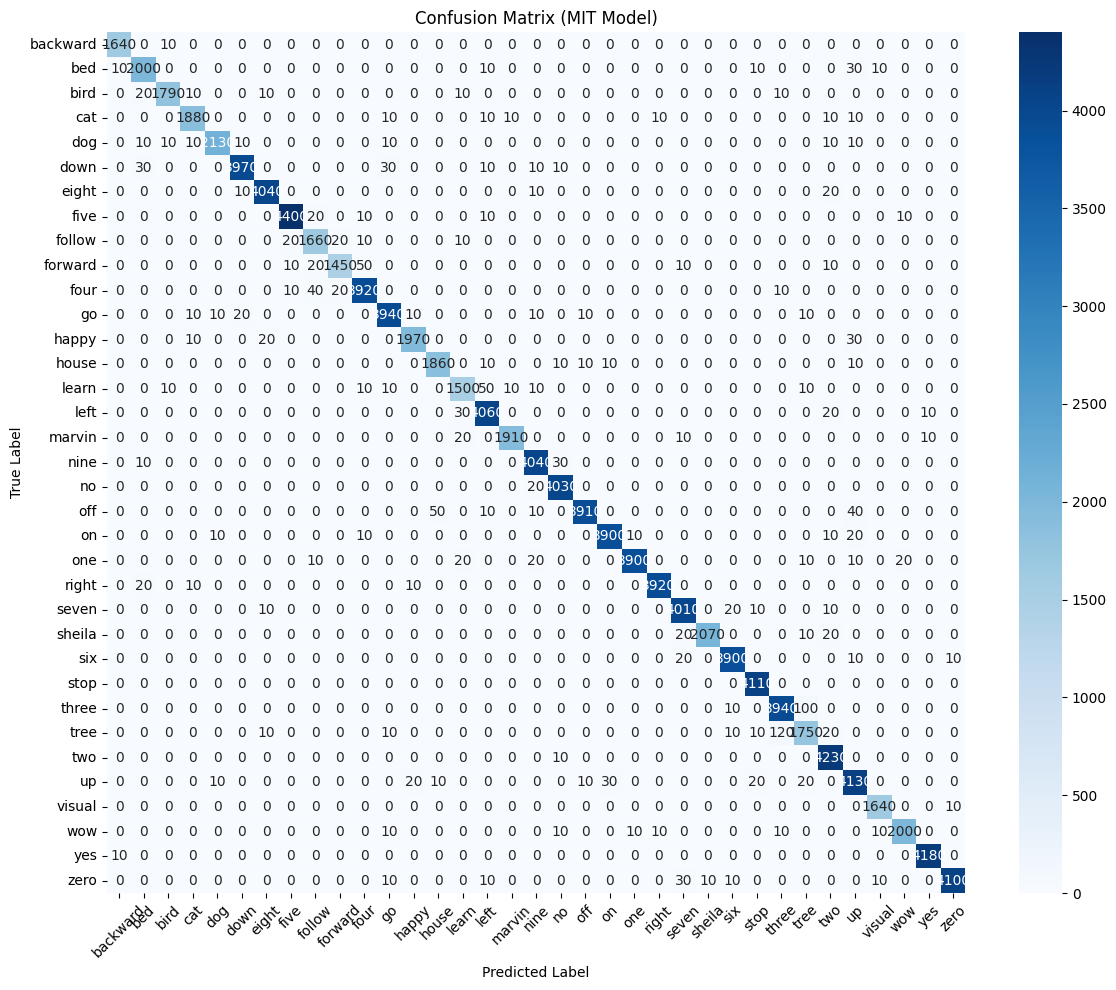

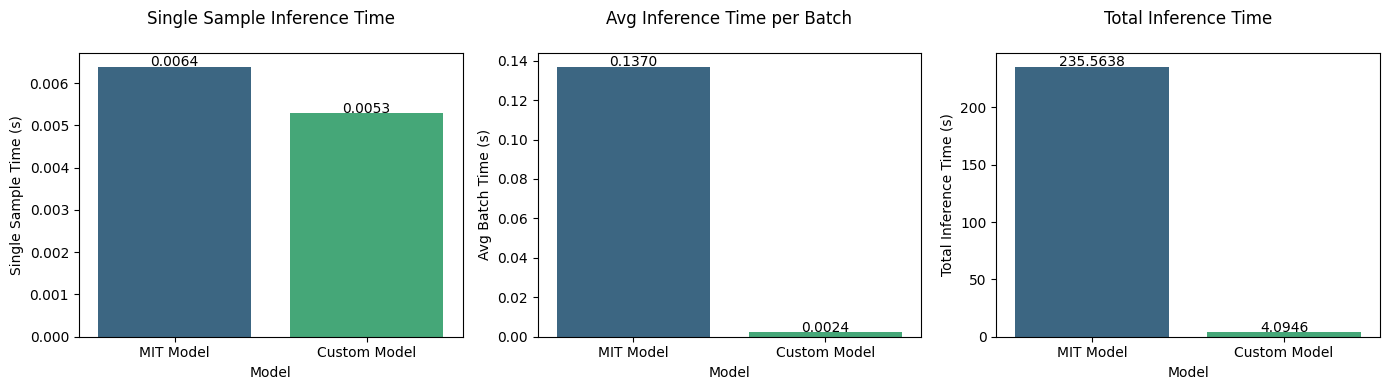

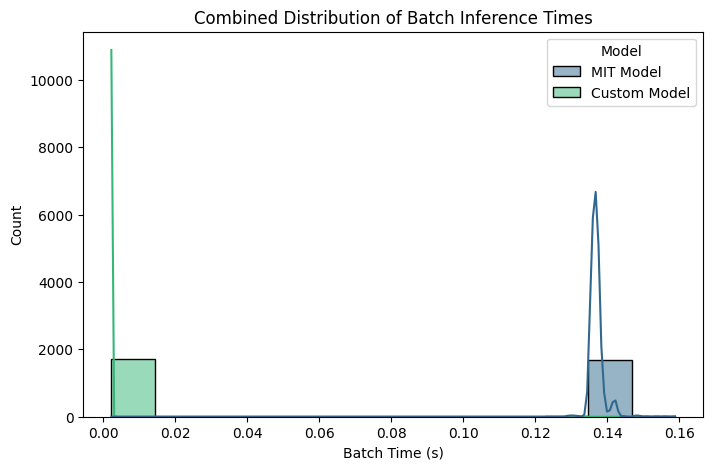

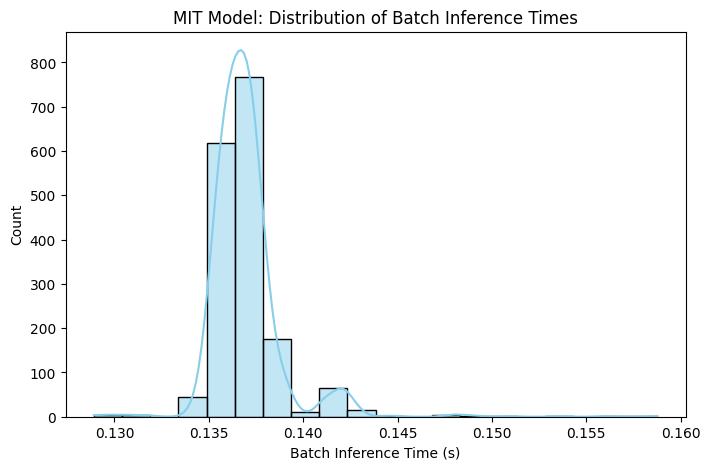

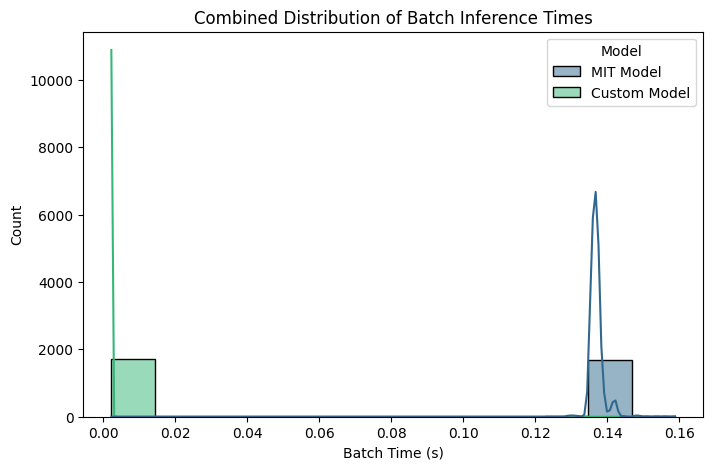

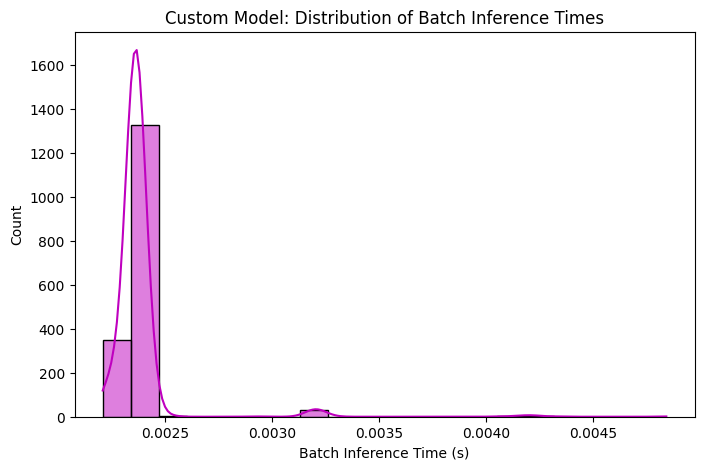

In [39]:
# ------------------------------
# Plot Confusion Matrix for MIT Model
# ------------------------------
cm = confusion_matrix(mit_all_targets, mit_all_preds)
labels_list = test_dataset.label_set

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (MIT Model)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ------------------------------
# Combined Timing Comparison Plots (MIT vs Custom)
# ------------------------------

model_names = ["MIT Model", "Custom Model"]

df_single = pd.DataFrame({
    "Model": model_names, 
    "SingleSampleTime": [mit_single_time, custom_single_time]
})
df_combined_batch = pd.DataFrame({
    "Model": model_names, 
    "AvgBatchTime": [mit_timing["avg_batch_time_sec"], custom_timing["avg_batch_time_sec"]]
})
df_combined_total = pd.DataFrame({
    "Model": model_names, 
    "TotalTime": [mit_timing["total_inference_time_sec"], custom_timing["total_inference_time_sec"]]
})

def annotate_bars(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10,
                    xytext=(0, -2),
                    textcoords='offset points')

plt.figure(figsize=(14, 4))

# Single Sample Inference Time
plt.subplot(1, 3, 1)
ax1 = sns.barplot(x="Model", y="SingleSampleTime", hue="Model", data=df_single, palette="viridis", dodge=False)
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
plt.ylabel("Single Sample Time (s)")
plt.title("Single Sample Inference Time\n")
annotate_bars(ax1)

# Avg batch time
plt.subplot(1, 3, 2)
ax2 = sns.barplot(x="Model", y="AvgBatchTime", hue="Model", data=df_combined_batch, palette="viridis", dodge=False)
if ax2.get_legend() is not None:
    ax2.get_legend().remove()
plt.ylabel("Avg Batch Time (s)")
plt.title("Avg Inference Time per Batch\n")
annotate_bars(ax2)

# Total Inference Time 
plt.subplot(1, 3, 3)
ax3 = sns.barplot(x="Model", y="TotalTime", hue="Model", data=df_combined_total, palette="viridis", dodge=False)
if ax3.get_legend() is not None:
    ax3.get_legend().remove()
plt.ylabel("Total Inference Time (s)")
plt.title("Total Inference Time\n")
annotate_bars(ax3)

plt.tight_layout()
plt.show()

# ------------------------------
# Combined distribution plot for batch inference times (MIT vs Custom)
# ------------------------------
combined_batch_times = mit_timing["batch_times"] + custom_timing["batch_times"]
model_labels = (["MIT Model"] * len(mit_timing["batch_times"])) + (["Custom Model"] * len(custom_timing["batch_times"]))
df_batch = pd.DataFrame({"Batch Time (s)": combined_batch_times, "Model": model_labels})

plt.figure(figsize=(8, 5))
sns.histplot(data=df_batch, x="Batch Time (s)", hue="Model", kde=True, palette="viridis", legend=True)
plt.title("Combined Distribution of Batch Inference Times")
plt.show()

# distribution of batch inference times for the MIT model
plt.figure(figsize=(8, 5))
sns.histplot(mit_timing["batch_times"], bins=20, kde=True, color="skyblue")
plt.xlabel("Batch Inference Time (s)")
plt.title("MIT Model: Distribution of Batch Inference Times")
plt.show()


plt.figure(figsize=(8, 5))
sns.histplot(data=df_batch, x="Batch Time (s)", hue="Model", kde=True, palette="viridis", legend=True)
plt.title("Combined Distribution of Batch Inference Times")
plt.show()


plt.figure(figsize=(8, 5))
sns.histplot(custom_timing["batch_times"], bins=20, kde=True, color="m")
plt.xlabel("Batch Inference Time (s)")
plt.title("Custom Model: Distribution of Batch Inference Times")
plt.show()


Classification Report (MIT Model):
               precision    recall  f1-score   support

    backward       0.99      0.99      0.99       165
         bed       0.96      0.97      0.96       207
        bird       0.98      0.97      0.98       185
         cat       0.97      0.97      0.97       194
         dog       0.99      0.97      0.98       220
        down       0.99      0.98      0.98       406
       eight       0.99      0.99      0.99       408
        five       0.99      0.99      0.99       445
      follow       0.95      0.97      0.96       172
     forward       0.97      0.94      0.95       155
        four       0.98      0.98      0.98       400
          go       0.98      0.98      0.98       402
       happy       0.98      0.97      0.98       203
       house       0.97      0.97      0.97       191
       learn       0.94      0.93      0.94       161
        left       0.97      0.99      0.98       412
      marvin       0.99      0.98      0.98  

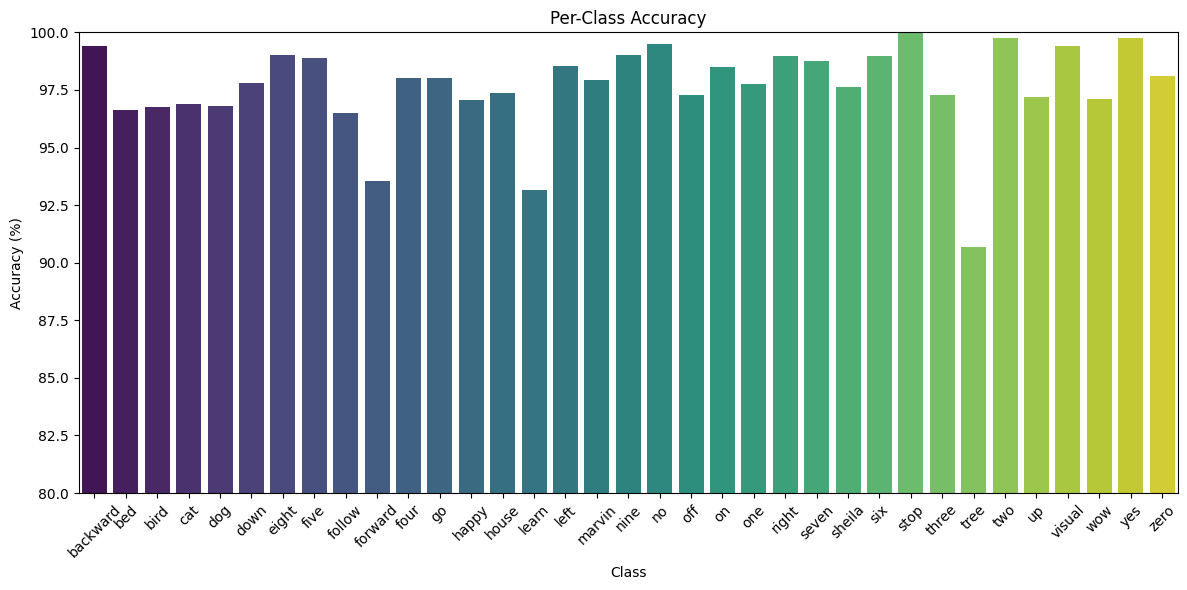

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Compute the classification report using MIT model results
report = classification_report(mit_all_targets, mit_all_preds, target_names=labels_list, zero_division=0)
print("Classification Report (MIT Model):\n", report)

# Compute the confusion matrix and normalize it to get per-class accuracy
cm = confusion_matrix(mit_all_targets, mit_all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
per_class_accuracy = np.diag(cm_normalized) * 100

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
df_per_class = pd.DataFrame({"Class": labels_list, "Accuracy": per_class_accuracy})
ax = sns.barplot(x="Class", y="Accuracy", hue="Class", data=df_per_class, palette="viridis", dodge=False)
if ax.get_legend() is not None:
    ax.get_legend().remove()
    
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.ylim(80, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
